<a href="https://colab.research.google.com/github/FLC-ML/raman-id/blob/master/Ramen_ID_Kaitlyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ResNet Training Model

In [4]:
# import packages
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from tensorflow.keras.layers import BatchNormalization, ZeroPadding1D, Conv1D, AveragePooling1D, MaxPooling1D
from tensorflow.keras.layers import Activation, Dense,  Flatten, Input, add, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model

# define resnet class
class ResNet:
  @staticmethod
  # create one residual block
  def residual_module(data, K, convLayers, chanDim=-1, reduce=False, reg=0.0001, bnEps=2e-5, bnMom=0.9, dropout=0.8, kernel_size=1):
    K = K*0.25
    shortcut = data
    x = data

    print("Resnet Block")
    for i in range(convLayers):
      x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(x)
      x = Activation("relu")(x)
      
      if (i == convLayers - 1):
        K = K*4
        x = Conv1D(int(K), kernel_size, use_bias=False, kernel_regularizer=l2(reg))(x)
      elif (i == int(convLayers/2)):
        x = Conv1D(int(K), kernel_size, use_bias=False, kernel_regularizer=l2(reg))(x)
      else:
        x = Conv1D(int(K), kernel_size, use_bias=False, kernel_regularizer=l2(reg))(x)
      if (dropout is not None):
        x = Dropout(dropout)(x)
     
      # print("**PostConvolution", x.shape)
      print("*ConvGroup", x.shape, K)

    if reduce:
      # shortcut = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(shortcut)
      shortcut = Conv1D(K, kernel_size, use_bias=False, kernel_regularizer=l2(reg))(shortcut)
    print("*Shortcut shape", shortcut.shape)

    x = add([x, shortcut])

    return x

  @staticmethod
  # build a model out of resblocks
  def build(inputShape, resLayers, classes, convLayers, filters, reg=0.0001, bnEps=2e-5, bnMom=0.9, dropout=None, kernel_size=1):
    chanDim = -1
    inputs = Input(shape=inputShape)

    # initial batchnorm and convolutional layer
    x = BatchNormalization(axis=chanDim, epsilon = bnEps, momentum=bnMom)(inputs)
    x = Conv1D(filters[0], 5, strides=2, use_bias=False, padding="same", kernel_regularizer=l2(reg))(inputs)
    
    x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(x)
    x = Activation("relu")(x)

       
    x = ResNet.residual_module(data=x, K=filters[1], convLayers=convLayers, reduce=True, bnEps=bnEps, bnMom=bnMom)

    for i in range(0, resLayers - 1):
      x = ResNet.residual_module(data=x, K=filters[1], convLayers=convLayers, bnEps=bnEps, bnMom=bnMom)
    
    x = BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(x)
    x = Activation("relu")(x)
    x = AveragePooling1D(8)(x)
    x = Flatten()(x)
    x = Dense(classes, kernel_regularizer=l2(reg))(x)
    x = Activation("softmax")(x)

    model = Model(inputs, x, name="resnet")

    return model

  @staticmethod
  def pretrain(save_directory, features, labels, verbose=1,
                                   batch_size=32, 
                                   epochs=10, 
                                   filters=(64, 100), 
                                   resLayers=1, 
                                   convLayers=1, 
                                   learningRate=0.01,   #decreased to 0.01 from 0.1
                                   dropout=0.8,
                                   kernel_size=1):
    X = features
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)


    # add depth channel
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # input shape is everything except for the number of samples 
    # number of classes is the number of unique items in y
    in_shape = X_train.shape[1:]
    n_classes = len(np.unique(y_train))

    # build model
    model = ResNet.build(inputShape=in_shape, classes=n_classes, convLayers=convLayers, resLayers=resLayers, filters=filters, dropout=dropout)

    # compile, train model
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=Adam(learningRate), metrics = ['accuracy'])
    
    ####### ADDED THIS #######
    tf.keras.utils.plot_model(model, to_file = 'Pretrained_Model_Architecture.png', show_shapes=True, show_layer_names=False)
    ##########################
    model.summary()

    model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs, verbose=verbose)

    # test accuracy
    accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
    print("(pretraining) Testing accuracy from within X_reference.npy and y_reference.npy:", accuracy[1])

    # Save the weights
    model.save(save_directory)

    # return model
    return model

  @staticmethod
  def finetune(save_directory, features, labels, verbose=1,
               learningRate=1e-4,   #increased to 1e-4 from 1e-5
               batch_size=10, 
               epochs=10):
    X = features
    y = labels

    # create 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    model = load_model(save_directory)
  
    model.compile(optimizer=Adam(learningRate),  # Very low learning rate
    loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose)
    loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
    print("(finetuning) Testing accuracy from within X_fine and y_fine: ", acc)
  
    return model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Pretraining Hyperparameters and Testing Model

In [5]:
# pretrain hyperparameters
batch_size = 100
epochs = 30
verbose = 1
filters = (64, 100)
resLayers = 1
convLayers = 1
learningRate = 0.001
dropout = 0.8
kernel_size = 1


# save_directory is the path where the model will be saved after pretraining 
# and the path where the finetuning model will read from
save_directory = '/content/drive/My Drive/ML Group/Individual Work/Kaitlyn/Saved Models/base.h5' 


# load data (specific to google drive)
X_test = np.load('/content/drive/My Drive/ML Group/Datasets/data/X_test.npy')
y_test = np.load('/content/drive/My Drive/ML Group/Datasets/data/y_test.npy')

X = np.load('/content/drive/My Drive/ML Group/Datasets/data/X_reference.npy')
y = np.load('/content/drive/My Drive/ML Group/Datasets/data/y_reference.npy')

X_fine = np.load('/content/drive/My Drive/ML Group/Datasets/data/X_finetune.npy')
y_fine = np.load('/content/drive/My Drive/ML Group/Datasets/data/y_finetune.npy')

print("X Reference Dataset Shape: ", X.shape)
print("y Reference Dataset Shape: ", y.shape)
print("X Test Dataset Shape: ", X_test.shape)
print("y Test Dataset Shape: ", y_test.shape)
print("X Finetuning Dataset Shape: ", X_fine.shape)
print("y Finetuning Dataset Shape: ", y_fine.shape)

indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y = y[indices]

pretrained_model = ResNet.pretrain(save_directory=save_directory, features=X, labels=y, verbose=verbose,
                                   batch_size=batch_size, 
                                   epochs=epochs, 
                                   filters=filters, 
                                   resLayers=resLayers, 
                                   convLayers=convLayers, 
                                   learningRate=learningRate,
                                   dropout=dropout,
                                   kernel_size=kernel_size)

pre_loss, pre_acc = pretrained_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
print("Testing loss, accuracy after pretraining from X_test and y_test:", pre_loss, pre_acc)


X Reference Dataset Shape:  (60000, 1000)
y Reference Dataset Shape:  (60000,)
X Test Dataset Shape:  (3000, 1000)
y Test Dataset Shape:  (3000,)
X Finetuning Dataset Shape:  (3000, 1000)
y Finetuning Dataset Shape:  (3000,)
Resnet Block
*ConvGroup (None, 500, 100) 100.0
*Shortcut shape (None, 500, 100)
Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 500, 64)      320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 500, 64)      256         conv1d[0][0]        

Finetuning

In [6]:
# finetune hyperparameters
ft_batch_size = 10
ft_epochs = 65
ft_learningRate = 1e-4    #increased to 1e-4 from 1e-5

finetuned_model = ResNet.finetune(save_directory=save_directory, features=X_fine, labels=y_fine, epochs=ft_epochs, learningRate=ft_learningRate, batch_size=ft_batch_size)

loss, acc = finetuned_model.evaluate(X_test, y_test, batch_size=ft_batch_size, verbose=verbose)
print("Pretrained accuracy: ", pre_acc)
print("Fintuned accuracy: ", acc)


Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 500, 64)      320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 500, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 500, 64)      0           batch_normalization_1[0][0]      
_____________________________________________________________________________________________

Get Predictions

In [7]:
y_pred = finetuned_model.predict(x = X_test)
predIndx = np.argmax(y_pred, axis = 1)
print("Predictions Shape:", y_pred.shape)
print("Classes:", y_pred[0].shape)
print(len(y_pred), "Predictions Made")


Predictions Shape: (3000, 30)
Classes: (30,)
3000 Predictions Made


Labels

In [8]:
# get labels and order

ORDER = [16, 17, 14, 18, 15, 20, 21, 24, 23, 26, 27, 28, 29, 25, 6, 7, 5, 3, 4,
         9, 10, 2, 8, 11, 22, 19, 12, 13, 0, 1]

STRAINS = {}
STRAINS[0] = "C. albicans"
STRAINS[1] = "C. glabrata"
STRAINS[2] = "K. aerogenes"
STRAINS[3] = "E. coli 1"
STRAINS[4] = "E. coli 2"
STRAINS[5] = "E. faecium"
STRAINS[6] = "E. faecalis 1"
STRAINS[7] = "E. faecalis 2"
STRAINS[8] = "E. cloacae"
STRAINS[9] = "K. pneumoniae 1"
STRAINS[10] = "K. pneumoniae 2"
STRAINS[11] = "P. mirabilis"
STRAINS[12] = "P. aeruginosa 1"
STRAINS[13] = "P. aeruginosa 2"
STRAINS[14] = "MSSA 1"
STRAINS[15] = "MSSA 3"
STRAINS[16] = "MRSA 1 (isogenic)"
STRAINS[17] = "MRSA 2"
STRAINS[18] = "MSSA 2"
STRAINS[19] = "S. enterica"
STRAINS[20] = "S. epidermidis"
STRAINS[21] = "S. lugdunensis"
STRAINS[22] = "S. marcescens"
STRAINS[23] = "S. pneumoniae 2"
STRAINS[24] = "S. pneumoniae 1"
STRAINS[25] = "S. sanguinis"
STRAINS[26] = "Group A Strep."
STRAINS[27] = "Group B Strep."
STRAINS[28] = "Group C Strep."
STRAINS[29] = "Group G Strep."

C_albicans = np.where(y==0)
C_glabrata = np.where(y==1)
K_aerogenes = np.where(y==2)
E_coli_1 = np.where(y==3)
E_coli_2 = np.where(y==4)
E_faecium = np.where(y==5)
E_faecalis_1 = np.where(y==6)
E_faecalis_2 = np.where(y==7)
E_cloacae = np.where(y==8)
K_pneumoniae_1 = np.where(y==9)
K_pneumoniae_2 = np.where(y==10)
P_mirabilis = np.where(y==11)
P_aeruginosa_1 = np.where(y==12)
P_aeruginosa_2 = np.where(y==13)
MSSA_1 = np.where(y==14)
MSSA_3 = np.where(y==15)
MRSA_1_iso = np.where(y==16)
MRSA_2 = np.where(y==17)
MSSA_2 = np.where(y==18)
S_enterica = np.where(y==19)
S_epidermidis = np.where(y==20)
S_lugdunensis = np.where(y==21)
S_marcescens = np.where(y==22)
S_pneumoniae_2 = np.where(y==23)
S_pneumoniae_1 = np.where(y==24)
S_sanguinis = np.where(y==25)
Group_A_Strep = np.where(y==26)
Group_B_Strep = np.where(y==27)
Group_C_Strep = np.where(y==28)
Group_G_Strep = np.where(y==29)

label = [STRAINS[i] for i in ORDER]

Classification Report

In [9]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas

cr = classification_report(y_test, predIndx, target_names = label)
print(cr)

                   precision    recall  f1-score   support

MRSA 1 (isogenic)       0.99      0.99      0.99       100
           MRSA 2       0.99      1.00      1.00       100
           MSSA 1       0.70      0.80      0.74       100
           MSSA 2       0.89      1.00      0.94       100
           MSSA 3       0.82      0.55      0.66       100
   S. epidermidis       0.99      1.00      1.00       100
   S. lugdunensis       1.00      0.21      0.35       100
  S. pneumoniae 1       0.55      0.87      0.68       100
  S. pneumoniae 2       0.74      0.71      0.72       100
   Group A Strep.       0.73      0.73      0.73       100
   Group B Strep.       0.91      0.92      0.92       100
   Group C Strep.       0.58      0.40      0.47       100
   Group G Strep.       0.72      0.87      0.79       100
     S. sanguinis       1.00      0.71      0.83       100
    E. faecalis 1       0.90      1.00      0.95       100
    E. faecalis 2       0.77      0.70      0.73       

Create Confusion Matrix

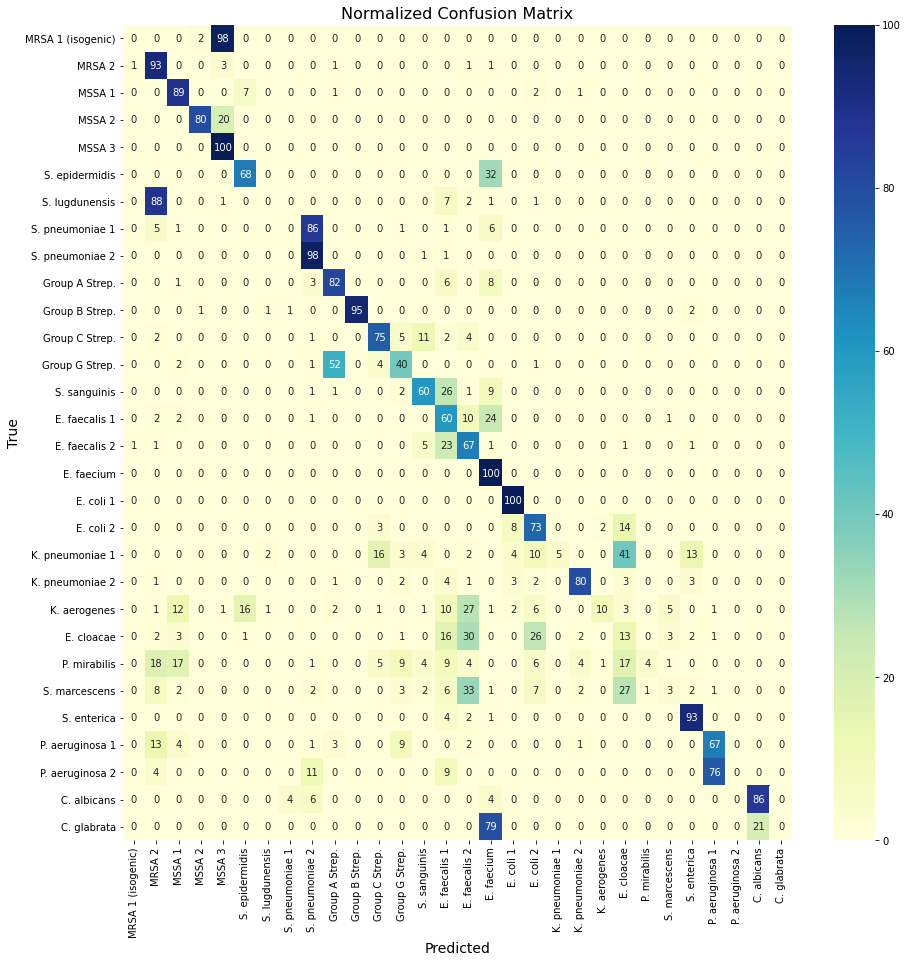

In [19]:
# plot confusion matrix

p_test = pretrained_model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test, labels = ORDER)

plt.figure(figsize = (15,15))
cm = 100*cm / cm.sum(axis = 1)[:,np.newaxis]

ax = sns.heatmap(cm, annot = True, cmap = "YlGnBu", fmt = '0.0f', 
                 xticklabels = label, yticklabels = label)
#ax.xaxis.tick_top()
plt.xticks(rotation = 90)
plt.title('Normalized Confusion Matrix', fontsize = 16)
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('True', fontsize = 14)
plt.savefig('Confusion Matrix')
plt.show()
